In [1]:
import torch
import os
import numpy as np

from copy import deepcopy

from HyperNetClasses import IdentityNet, NormalVariationalNet

from RegressionDataset import SineDataset, LineDataset

from _utils import train_val_split_regression

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# import the meta-learning algorithm class of interest
from Maml import Maml
from Vampire2 import Vampire2

In [3]:
# the index to concatenate to the name of a saved check-point, which will be loaded for visualization
resume_maml = 300
resume_vampire2 = 100

In [4]:
config = {}

config['logdir'] = '.'

config['datasource'] = ['SineLine']
config['network_architecture'] = 'FcNet'
config['num_ways'] = 1
config['k_shot'] = 5
config['v_shot'] = 10
config['num_models'] = 16
config['KL_weight'] = 1e-5

config['inner_lr'] = 0.001
config['num_inner_updates'] = 5
config['meta_lr'] = 1e-3

config['train_flag'] = False
config['num_episodes'] = 1

config['device'] = torch.device('cuda:0' if torch.cuda.is_available() else torch.device('cpu'))

config['loss_function'] = torch.nn.MSELoss()
config['train_val_split_function'] = train_val_split_regression

config['first_order'] = True

In [5]:
config_maml = deepcopy(config)
config_maml['logdir'] = os.path.join(config['logdir'], 'meta_learning', 'maml', config['network_architecture'])
maml = Maml(config=config_maml)

config_vampire2 = deepcopy(config)
config_vampire2['logdir'] = os.path.join(config['logdir'], 'meta_learning', 'vampire2', config['network_architecture'])
vampire2 = Vampire2(config=config_vampire2)

In [6]:
sine_generator = SineDataset(amplitude_range=[2, 5], phase_range=[0, np.pi], noise_std=0.3, x_range=[-5, 5], num_samples=50)
line_generator = LineDataset(slope_range=[-3, 3], intercept_range=[-3, 3], x_range=[-5, 5], num_samples=50, noise_std=0.3)

In [7]:
regression_dataset = torch.utils.data.ConcatDataset(datasets=[sine_generator, line_generator])

train_dataloader = torch.utils.data.DataLoader(dataset=regression_dataset)
test_dataloader = torch.utils.data.DataLoader(dataset=regression_dataset)

In [8]:
models = {}
models['maml'] = maml.load_model(resume_epoch=resume_maml, eps_dataloader=train_dataloader, hyper_net_class=IdentityNet)
models['vampire2'] = vampire2.load_model(resume_epoch=resume_vampire2, eps_dataloader=train_dataloader, hyper_net_class=NormalVariationalNet)

/home/n10/venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Number of parameters of the base network = 1,761.

Number of parameters of the base network = 1,761.



In [9]:
# set training mode to disable dropout
for meta_learning_algorithm in ['maml', 'vampire2']:
    models[meta_learning_algorithm]['f_base_net'].eval()

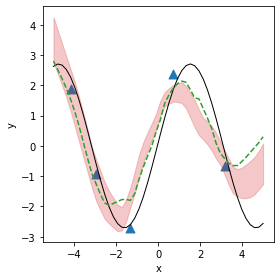

In [10]:
x = torch.linspace(start=-5, end=5, steps=50, device=config['device'])

temp = np.random.binomial(n=1, p=0.5)
if temp == 1:
    y = sine_generator.generate_label()
else:
    y = line_generator.generate_label()

y_noisy = y + torch.randn_like(input=y) * sine_generator.noise_std

# split data into train and validation
split_data = config['train_val_split_function'](eps_data=[sine_generator.x[None, :], y_noisy[None, :]], k_shot=config['k_shot'])

# move data to GPU (if there is a GPU)
x_t = split_data['x_t'].to(config['device'])
y_t = split_data['y_t'].to(config['device'])
x_v = split_data['x_v'].to(config['device'])
y_v = split_data['y_v'].to(config['device'])

# MAML
adapted_hyper_net = maml.adaptation(x=x_t, y=y_t, model=models['maml'])
y_maml = maml.prediction(x=x[:, None], adapted_hyper_net=adapted_hyper_net, model=models['maml'])

# Vampire2
y_list = []
for _ in range(config_vampire2['num_models']):
    adapted_hyper_net = vampire2.adaptation(x=x_t, y=y_t, model=models['vampire2'])
    y_vampire2 = vampire2.prediction(x=x[:, None], adapted_hyper_net=adapted_hyper_net, model=models['vampire2'])
    y_vampire2 = torch.stack(tensors=y_vampire2, dim=0)
    y_vampire2 = torch.squeeze(input=y_vampire2)
    y_list.append(y_vampire2)

y_vampire2 = torch.cat(tensors=y_list, dim=0)
y_vampire2_mean = torch.mean(input=y_vampire2, dim=0).detach().cpu().numpy()
y_vampire2_std = torch.std(input=y_vampire2, dim=0, unbiased=True).detach().cpu().numpy()

# plot
y = torch.squeeze(y)

plt.figure(figsize=(4, 4))
plt.scatter(x=x_t.cpu().numpy(), y=y_t.cpu().numpy(), s=80, marker='^', color='C0')
plt.plot(x.cpu().numpy(), y, color='black', linewidth=1, linestyle='-')
plt.plot(x.cpu().numpy(), y_maml.detach().cpu().numpy(), color='C2', linestyle='--')
plt.fill_between(
    x=x.cpu().numpy(),
    y1=y_vampire2_mean + 3 * y_vampire2_std,
    y2=y_vampire2_mean - 3 * y_vampire2_std,
    color='C3',
    alpha=0.25
)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()